In [148]:
%pip install spectral

Note: you may need to restart the kernel to use updated packages.


In [149]:
import hytools.masks.cloud

# Define a function to override the original `zhai_cloud`
def patched_zhai_cloud(hy_obj, cloud, shadow, T1=0.01, t2=.1, t3=.25, t4=.5, T7=9, T8=9):
    blue = hy_obj.get_wave(444)   # New wavelength
    green = hy_obj.get_wave(560)  # New wavelength
    red = hy_obj.get_wave(650)    # New wavelength
    nir = hy_obj.get_wave(862)    # New wavelength
    
    # Call the original function but with modified parameters
    return hytools.masks.cloud.zhai_cloud(hy_obj, cloud, shadow, T1, t2, t3, t4, T7, T8)

# Patch the function in the `hytools.masks.cloud` module
hytools.masks.cloud.zhai_cloud = patched_zhai_cloud

# Now, when `zhai_cloud()` is called from `hytools`, it will use the modified version


In [150]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import nbconvert
import time
import os
import drone_cor_sup.utils as drone_utils

In [151]:
os.getcwd()

'/home/jovyan/data-store/cross-sensor-cal'

In [152]:
%load_ext autoreload
%autoreload 2

import spectral_unmixing_tools_original as el_spectral

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
base_dir = "/home/jovyan/data-store/earthlab/macrosystems/field-data/output"
package = "AOP-GORDON-08-14-23-ExportPackage"
data_dir = os.path.join(base_dir, package)
output_dir = data_dir
file_path = os.path.join(data_dir,'aligned_orthomosaic.tif')
slope_path = os.path.join(data_dir,'aligned_slope.tif')
aspect_path = os.path.join(data_dir,'aligned_aspect.tif')
chm_path = os.path.join(data_dir,'aligned_chm.tif')

date_time_str = '2023-08-15 20:58:39'
chm_path

#scripts
neon2envi_script = "neon2envi2_generic.py"
image_correction_script = "image_correct.py"

In [154]:
# Define Wavelengths and Full Width at Half Maximum (FWHM) for spectral bands
wavelengths = [444, 475, 531, 560, 650, 668, 705, 717, 740, 862]  # In nm
fwhm = [28, 32, 14, 27, 16, 14, 10, 12, 18, 57]

longitudes, latitudes, cols, rows = drone_utils.pixel_to_coord(file_path)

# Convert the date and time to UTC. The time given is 2:34 PM, which is 14:34 in 24-hour format
date_time_str = date_time_str #'2023-08-01 21:34:00'

azimuth, zenith = drone_utils.get_computed_azimuth_zenith(file_path, date_time_str, latitudes, longitudes)

Band1 has shape (835, 1179)
eastings shape (835, 1179)


In [155]:
h5_filepath = drone_utils.tiff_to_h5(file_path, slope_path, aspect_path, chm_path, zenith, azimuth, wavelengths, fwhm, output_dir)
print(h5_filepath)

HDF5 file created: /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic.h5
/home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic.h5


In [156]:
NEON_image_path = h5_filepath
# output_dir = '/home/jovyan/data-store/cross-sensor-cal/output'

In [157]:
print(os.path.exists(NEON_image_path))  # Should return True
print(os.path.isdir(output_dir))  # Should return True


True
True


In [158]:
drone_utils.process_hdf5_with_neon2envi(NEON_image_path, neon2envi_script, output_dir)
print('done')

Using script: /home/jovyan/data-store/cross-sensor-cal/neon2envi2_generic.py
Executing command: /opt/conda/envs/macrosystems/bin/python /home/jovyan/data-store/cross-sensor-cal/neon2envi2_generic.py -anc --images /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic.h5 --output_dir /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage
2025-02-04 00:44:52,790	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.76gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-02-04 00:44:53,934	INFO worker.py:1673 --

In [159]:
neond13_basefilename = drone_utils.get_neon_filename(file_path).replace('.tif', '')
neond13_directory = os.path.join(output_dir, neond13_basefilename)
#'/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic'
neond13_directory

'/home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic'

In [160]:
config_files = drone_utils.generate_config_files(neond13_directory)
print("Generated config files:", config_files)

Generated config files: ['/home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_test_aligned_orthomosaic_config__reflectance.json', '/home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_test_aligned_orthomosaic_config__anc.json']


In [161]:
#you should try and take it from the generate_config_files output
json_path = f"{neond13_directory}/{neond13_basefilename}_config__reflectance.json"
# jason_path = '/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_aligned_orthomosaic_config__reflectance.json'
drone_utils.brdf_topo_correct_image(image_correction_script, json_path)

Using script: /home/jovyan/data-store/cross-sensor-cal/image_correct.py
Executing command: /opt/conda/envs/macrosystems/bin/python /home/jovyan/data-store/cross-sensor-cal/image_correct.py /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_test_aligned_orthomosaic_config__reflectance.json
2025-02-04 00:45:01,214	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.68gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-02-04 00:45:02,348	INFO worker.py:1673 -- Started a local Ray instance.
/home/jovyan/data-store/earthlab/macrosyste

In [162]:

# change here based on AOP underflights or not. If underflights, the polygons are at the AOP geojson file. If not within the AOP, the polygons are at uas geojson file
# geojson_path = '/home/jovyan/data-store/cross-sensor-cal/uas_polygons_1_24_2025_analysis_ready.geojson'
# geojson_path_half = '/home/jovyan/data-store/cross-sensor-cal/uas_polygons_1_24_2025_analysis_ready_half_diam.geojson'

# you can copy these from macrosystems/field-data/analysis_ready_polygons/
# geojson_path_aop = '/home/jovyan/data-store/cross-sensor-cal/aop_macrosystems_data_1_7_25.geojson'
geojson_path_aop = '/home/jovyan/data-store/cross-sensor-cal/aop_polygons_1_24_2025_analysis_ready.geojson'
geojson_path_aop_half = '/home/jovyan/data-store/cross-sensor-cal/aop_polygons_1_24_2025_analysis_ready_half_diam.geojson'
geojson_path_uas = '/home/jovyan/data-store/cross-sensor-cal/uas_polygons_1_24_2025_analysis_ready.geojson'
geojson_path_uas_half = '/home/jovyan/data-store/cross-sensor-cal/uas_polygons_1_24_2025_analysis_ready_half_diam.geojson'

geojson_path = geojson_path_uas
geojson_path_half = geojson_path_uas_half

if package.lower().startswith("aop"):
    geojson_path = geojson_path_aop
    geojson_path_half = geojson_path_aop_half
    

main_image_name = os.path.basename(neond13_directory)
raster_path = os.path.join(neond13_directory, main_image_name + '__reflectance' )
raster_path_2 = os.path.join(neond13_directory, main_image_name + '__reflectance_corrected_flipped' )

output_csv = f"{neond13_directory}/NEON_D13_NIWO_reflectance_per_pixel.csv"
output_csv_half = f"{neond13_directory}/NEON_D13_NIWO_reflectance_per_pixel_half.csv"

print(raster_path)
print(f"geojson_path - {geojson_path}\n geojson_path_half - {geojson_path_half}")

/home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_test_aligned_orthomosaic__reflectance
geojson_path - /home/jovyan/data-store/cross-sensor-cal/aop_polygons_1_24_2025_analysis_ready.geojson
 geojson_path_half - /home/jovyan/data-store/cross-sensor-cal/aop_polygons_1_24_2025_analysis_ready_half_diam.geojson


In [163]:
tiff_path = file_path  # Path to your reference TIFF file
tiff_transform = drone_utils.get_tiff_transform(tiff_path)

print("TIFF Transform:", tiff_transform)

TIFF Transform: | 0.25, 0.00, 457268.25|
| 0.00,-0.25, 4429034.75|
| 0.00, 0.00, 1.00|


In [164]:
envi_path = raster_path
output_path = raster_path_2

drone_utils.flip_envi_and_preserve_metadata(envi_path, output_path, tiff_transform)

Flipping ENVI image to match TIFF orientation...
Corrected ENVI file saved to /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_test_aligned_orthomosaic__reflectance_corrected_flipped with preserved metadata.


In [165]:
# Example usage
envi_path = raster_path_2
output_path = raster_path_2

drone_utils.fix_envi_orientation(envi_path, output_path)

Reflipping ENVI image to restore correct orientation...
Corrected ENVI file saved to /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_test_aligned_orthomosaic__reflectance_corrected_flipped with preserved metadata.


In [166]:
polygons = drone_utils.check_and_reproject(geojson_path, raster_path_2)


🔄 Reprojecting GeoJSON from EPSG:5070 to EPSG:26913


In [167]:
drone_utils.extract_pixel_reflectance(geojson_path, raster_path_2, output_csv)

🔄 Reprojecting GeoJSON from EPSG:5070 to EPSG:26913
✅ 58 polygons found within raster extent.
📂 Reflectance data saved to: /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_reflectance_per_pixel.csv


In [168]:
drone_utils.extract_pixel_reflectance(geojson_path_half, raster_path_2, output_csv_half)

🔄 Reprojecting GeoJSON from EPSG:5070 to EPSG:26913
✅ 58 polygons found within raster extent.
📂 Reflectance data saved to: /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_reflectance_per_pixel_half.csv


In [169]:
os.getcwd()

'/home/jovyan/data-store/cross-sensor-cal'

In [170]:
envi_image= f"{neond13_directory}/{neond13_basefilename}__reflectance"
envi = ht.HyTools()
envi.read_file(envi_image,'envi')


In [171]:
original_image= f"{neond13_directory}/{neond13_basefilename}"

og_envi = ht.HyTools()
og_envi.read_file(original_image,'envi')

In [172]:
line = envi.get_line(100, corrections = [])
band = envi.get_band(5)
wave = envi.get_wave(668)
pixel = envi.get_pixels([100],[200])
#anc = envi.get_anc('sensor_zn',radians =False)

In [173]:
topo_coeffs = f"{neond13_directory}/{neond13_basefilename}_topo_coeffs__reflectance.json"
envi.load_coeffs(topo_coeffs,'topo')

brdf_coeffs = f"{neond13_directory}/{neond13_basefilename}_brdf_coeffs__reflectance.json"
envi.load_coeffs(brdf_coeffs,'brdf')

In [174]:
def show_rgb(hy_obj,r=668,g=560,b=444, correct= []):

    rgb=  np.stack([hy_obj.get_wave(r,corrections= correct),
                    hy_obj.get_wave(g,corrections= correct),
                    hy_obj.get_wave(b,corrections= correct)])
    rgb = np.moveaxis(rgb,0,-1).astype(float)
    rgb[rgb ==hy_obj.no_data] = np.nan

    bottom = np.nanpercentile(rgb,5,axis = (0,1))
    top = np.nanpercentile(rgb,95,axis = (0,1))
    rgb = np.clip(rgb,bottom,top)

    rgb = (rgb-np.nanmin(rgb,axis=(0,1)))/(np.nanmax(rgb,axis= (0,1))-np.nanmin(rgb,axis= (0,1)))

    height = int(hy_obj.lines/hy_obj.columns)

    fig  = plt.figure(figsize = (7,7) )
    plt.imshow(rgb)
    plt.show()
    plt.close()
    


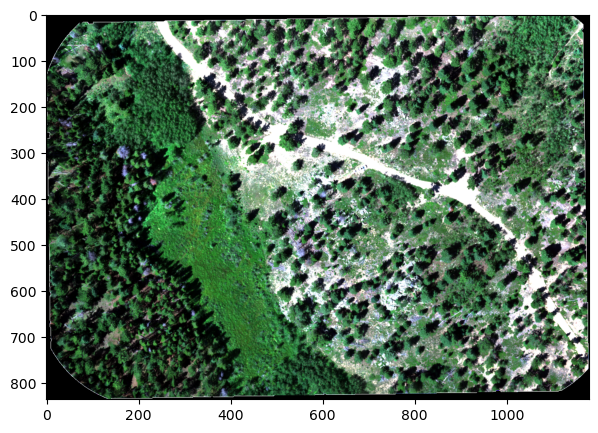

In [175]:
show_rgb(envi, correct= [])

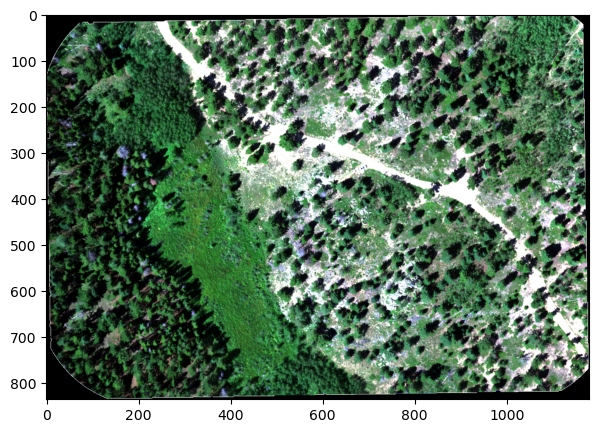

In [176]:
show_rgb(og_envi)

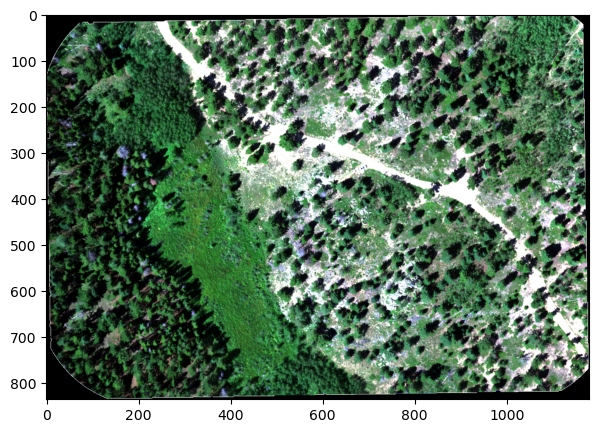

In [177]:
show_rgb(og_envi, correct = ['brdf'])

In [178]:
og_envi.get_wave(862, corrections= ['topo', 'brdf'])

memmap([[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]], dtype=int16)

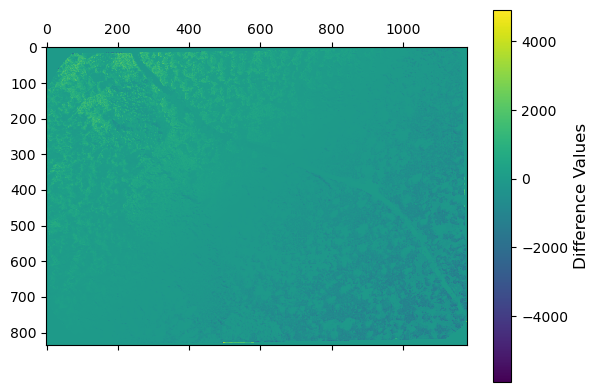

In [179]:
difference = (envi.get_wave(862)) - og_envi.get_wave(862)
plt.matshow(difference, cmap='viridis')  # 'viridis' is the default colormap in Matplotlib

# Add a colorbar to act as a legend for the values
cbar = plt.colorbar()
cbar.set_label('Difference Values', fontsize=12)  # Label for the colorbar

# Show the plot
plt.show()

In [180]:
envi.wavelengths

array([444., 475., 531., 560., 650., 668., 705., 717., 740., 862.])

In [181]:
corrected = envi.get_pixels([100],[300])
corrected


array([[3479.956 ],
       [4031.4387],
       [4994.4985],
       [5691.6255],
       [7243.6704],
       [7404.8394],
       [7661.8335],
       [7911.538 ],
       [8363.741 ],
       [9049.829 ]], dtype=float32)

In [182]:
reflectance = corrected.flatten()
reflectance

array([3479.956 , 4031.4387, 4994.4985, 5691.6255, 7243.6704, 7404.8394,
       7661.8335, 7911.538 , 8363.741 , 9049.829 ], dtype=float32)

In [183]:
og_envi2 = og_envi.get_pixels([100],[300])
og_envi2

array([[3192],
       [3713],
       [4766],
       [5447],
       [6877],
       [6997],
       [7258],
       [7509],
       [7996],
       [8617]], dtype=int16)

In [184]:
old_ref = og_envi2.flatten()
old_ref

array([3192, 3713, 4766, 5447, 6877, 6997, 7258, 7509, 7996, 8617],
      dtype=int16)

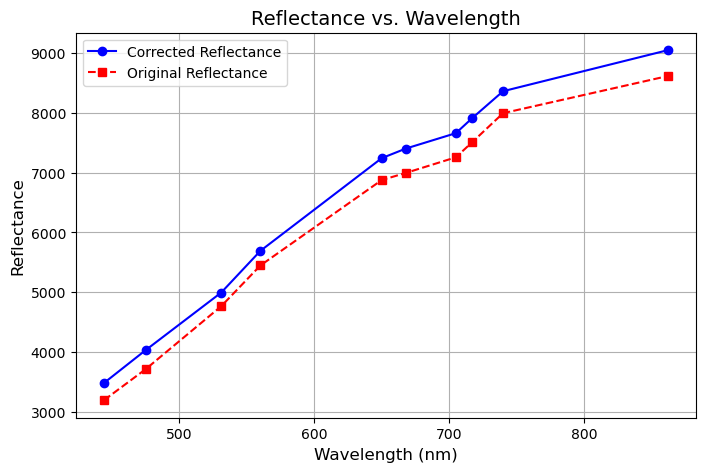

In [185]:
import matplotlib.pyplot as plt

# Create the figure and axes
plt.figure(figsize=(8, 5))  # Set figure size

# Plot both reflectance curves on the same graph
plt.plot(envi.wavelengths, reflectance, marker='o', linestyle='-', color='b', label='Corrected Reflectance')
plt.plot(envi.wavelengths, old_ref, marker='s', linestyle='--', color='r', label='Original Reflectance')

# Labels and title
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Reflectance", fontsize=12)
plt.title("Reflectance vs. Wavelength", fontsize=14)

# Legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Use the below code to generate files for all dir, only when you are confident that the above code is working

In [80]:
base_dir = "/home/jovyan/data-store/earthlab/macrosystems/field-data/output"

# Dictionary mapping package names to their respective datetime strings
date_time_dict = {
    # "AOP-GORDON-08-14-23-ExportPackage": "2023-08-16 18:53:18",
    # Add other package datetime mappings here
    
    "SPR1-06-28-23-ExportPackage" : "2023-06-28 17:30:21",
    "SH67W1-07-11-23-ExportPackage" : "2023-07-11 19:07:39",
    "SH67_1-07-07-23-ExportPackage" : "2023-07-07 17:56:05",
    "OR3-08-16-23-ExportPackage" : "2023-08-16 20:28:40",
    "JC1-07-11-23-ExportPackage" : "2023-07-11 21:24:34",
    "GAH2-07-25-23-ExportPackage" : "2023-07-25 17:44:17",
    "GAH1-07-25-23-ExportPackage" : "2023-07-25 18:21:38",
    "CW3-08-16-23-ExportPackage" : "2023-08-16 17:20:17",
    "CW2-08-16-23-ExportPackage" : "2023-08-16 18:18:03",
    "CW1-08-08-23-ExportPackage" : "2023-08-08 18:12:39",
    "AOP-Ruby-08-14-23-ExportPackage" : "2023-08-16 18:53:18",
    "AOP-MRS2-08-14-23-ExportPackage" : "2023-08-15 17:51:04",
    "AOP-GORDON-08-14-23-ExportPackage" : "2023-08-15 20:58:39",
    "AOP-GOLDHILL-08-14-23-ExportPackage" : "2023-08-15 19:53:07"
}

# Scripts
neon2envi_script = "neon2envi2_generic.py"
image_correction_script = "image_correct.py"

# Define Wavelengths and Full Width at Half Maximum (FWHM) for spectral bands
wavelengths = [444, 475, 531, 560, 650, 668, 705, 717, 740, 862]  # In nm
fwhm = [28, 32, 14, 27, 16, 14, 10, 12, 18, 57]

# Iterate over all directories (packages) in the base directory
for package in os.listdir(base_dir):
    # if package != "AOP-GORDON-08-14-23-ExportPackage":
    #     continue
    package_path = os.path.join(base_dir, package)
    if not os.path.isdir(package_path):
        continue  # Skip files, only process directories
    print(f"Starting processing for {package}\n")
    date_time_str = date_time_dict.get(package, "Unknown Date")
    if date_time_str == "Unknown Date":
        print(f"Skipping {package}, no datetime entry found.")
        continue

    
    try:
        output_dir = package_path
        file_path = os.path.join(package_path, 'aligned_orthomosaic.tif')
        slope_path = os.path.join(package_path, 'aligned_slope.tif')
        aspect_path = os.path.join(package_path, 'aligned_aspect.tif')
        chm_path = os.path.join(package_path, 'aligned_chm.tif')
    
        longitudes, latitudes, cols, rows = drone_utils.pixel_to_coord(file_path)
        azimuth, zenith = drone_utils.get_computed_azimuth_zenith(file_path, date_time_str, latitudes, longitudes)
    
        h5_filepath = drone_utils.tiff_to_h5(file_path, slope_path, aspect_path, chm_path, zenith, azimuth, wavelengths, fwhm, output_dir)
        
        if not os.path.exists(h5_filepath):
            print(f"HDF5 file creation failed for {package}")
            continue
        
        drone_utils.process_hdf5_with_neon2envi(h5_filepath, neon2envi_script, output_dir)
        
        neond13_basefilename = drone_utils.get_neon_filename(file_path).replace('.tif', '')
        neond13_directory = os.path.join(output_dir, neond13_basefilename)
        config_files = drone_utils.generate_config_files(neond13_directory)
        
        json_path = os.path.join(neond13_directory, f"{neond13_basefilename}_config__reflectance.json")
        drone_utils.brdf_topo_correct_image(image_correction_script, json_path)
    
        # geojson_path_aop = '/home/jovyan/data-store/cross-sensor-cal/aop_macrosystems_data_1_7_25.geojson'
        geojson_path_aop = '/home/jovyan/data-store/cross-sensor-cal/aop_polygons_1_24_2025_analysis_ready.geojson'
        geojson_path_aop_half = '/home/jovyan/data-store/cross-sensor-cal/aop_polygons_1_24_2025_analysis_ready_half_diam.geojson'
        geojson_path_uas = '/home/jovyan/data-store/cross-sensor-cal/uas_polygons_1_24_2025_analysis_ready.geojson'
        geojson_path_uas_half = '/home/jovyan/data-store/cross-sensor-cal/uas_polygons_1_24_2025_analysis_ready_half_diam.geojson'
        
        geojson_path = geojson_path_uas
        geojson_path_half = geojson_path_uas_half
        
        if package.lower().startswith("aop"):
            geojson_path = geojson_path_aop
            geojson_path_half = geojson_path_aop_half
        
        raster_path = os.path.join(neond13_directory, f"{neond13_basefilename}__reflectance")
        raster_path_2 = os.path.join(neond13_directory, f"{neond13_basefilename}__reflectance_corrected_flipped" )
        output_csv = os.path.join(neond13_directory, "NEON_D13_NIWO_reflectance_per_pixel.csv")
    
        tiff_path = file_path  # Path to your reference TIFF file
        tiff_transform = drone_utils.get_tiff_transform(tiff_path)
        envi_path = raster_path
        output_path = raster_path_2
        drone_utils.flip_envi_and_preserve_metadata(envi_path, output_path, tiff_transform)
        envi_path = raster_path_2
        output_path = raster_path_2
        drone_utils.fix_envi_orientation(envi_path, output_path)
        polygons = drone_utils.check_and_reproject(geojson_path, raster_path_2)
        drone_utils.extract_pixel_reflectance(geojson_path, raster_path_2, output_csv)
        drone_utils.extract_pixel_reflectance(geojson_path_half, raster_path_2, output_csv_half)
    except:
        print(f"Something went wrong - please debug package - {package}")
    
    print(f"Processing completed for {package}\n")
    print("****************************************************************************************\n"*3)


Starting processing for SPR1-06-28-23-ExportPackage

Band1 has shape (542, 603)
eastings shape (542, 603)
HDF5 file created: /home/jovyan/data-store/earthlab/macrosystems/field-data/output/SPR1-06-28-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic.h5
Using script: /home/jovyan/data-store/cross-sensor-cal/neon2envi2_generic.py
Executing command: /opt/conda/envs/macrosystems/bin/python /home/jovyan/data-store/cross-sensor-cal/neon2envi2_generic.py -anc --images /home/jovyan/data-store/earthlab/macrosystems/field-data/output/SPR1-06-28-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic.h5 --output_dir /home/jovyan/data-store/earthlab/macrosystems/field-data/output/SPR1-06-28-23-ExportPackage
2025-02-04 00:32:18,448	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker contai